# Predictions by Week Day

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import RocCurveDisplay

In [2]:
df = pd.read_csv('db_criminalBehaviour_byWeekDay.csv')
df.drop(['categories', 'Unnamed: 0', 'index'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13810 entries, 0 to 13809
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   year            13810 non-null  int64 
 1   month           13810 non-null  int64 
 2   week_day        13810 non-null  object
 3   problem_type_1  13810 non-null  object
 4   count           13810 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 539.6+ KB


In [3]:
target = df['count']
train_data = df.drop(['count'], axis=1)

In [5]:
num_features = ['year', 'month']
cat_features = ['problem_type_1','week_day']

In [6]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=4)),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])

In [7]:
models2test = [
    SVR(),
    DecisionTreeRegressor(max_depth=2, random_state=4392),
    ExtraTreesRegressor(n_estimators=100, random_state=4392),
    GradientBoostingRegressor(random_state=4392),
]

In [8]:
scores_classif = {}
for classifier in models2test:
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])


    stratKFold = TimeSeriesSplit(n_splits=5)
    scores = cross_validate(pipeline, train_data, target, cv=stratKFold,
                            scoring=('r2', 'neg_mean_absolute_error', 'explained_variance'),
                            return_train_score=True, return_estimator=True, return_indices=True) 
    
    print('\n')
    print('-----------------------------------')
    print(str(classifier))
    print('-----------------------------------')

    print('\n')
    print('train_r2 mean: ',scores['train_r2'].mean())
    print('train_r2 std: ',scores['train_r2'].std())
    print('test_r2 mean: ',scores['test_r2'].mean())
    print('test_r2 std: ',scores['test_r2'].std())

    print('\n')
    print('train_neg_mean_absolute_error mean: ',scores['train_neg_mean_absolute_error'].mean())
    print('train_neg_mean_absolute_error std: ',scores['train_neg_mean_absolute_error'].std())
    print('test_neg_mean_absolute_error mean: ',scores['test_neg_mean_absolute_error'].mean())
    print('test_neg_mean_absolute_error std: ',scores['test_neg_mean_absolute_error'].std())

    print('\n')
    print('train_explained_variance mean: ',scores['train_explained_variance'].mean())
    print('train_explained_variance std: ',scores['train_explained_variance'].std())
    print('test_explained_variance mean: ',scores['test_explained_variance'].mean())
    print('test_explained_variance std: ',scores['test_explained_variance'].std())

    clf_txt = str(classifier).split('(')[0]
    scores_classif[clf_txt] = scores



-----------------------------------
SVR()
-----------------------------------


train_r2 mean:  0.7196785801263306
train_r2 std:  0.05856647949183247
test_r2 mean:  0.3876291275244069
test_r2 std:  0.2578448439112225


train_neg_mean_absolute_error mean:  -1.949983070811377
train_neg_mean_absolute_error std:  0.1898772218434933
test_neg_mean_absolute_error mean:  -3.4224235899423983
test_neg_mean_absolute_error std:  0.769894789474572


train_explained_variance mean:  0.7320082394309408
train_explained_variance std:  0.052331166463502075
test_explained_variance mean:  0.4835711837335578
test_explained_variance std:  0.1933427023976259


-----------------------------------
DecisionTreeRegressor(max_depth=2, random_state=4392)
-----------------------------------


train_r2 mean:  0.5018364047396824
train_r2 std:  0.05053552559493003
test_r2 mean:  0.22053185618853827
test_r2 std:  0.1694396329679101


train_neg_mean_absolute_error mean:  -3.428313392830939
train_neg_mean_absolute_error

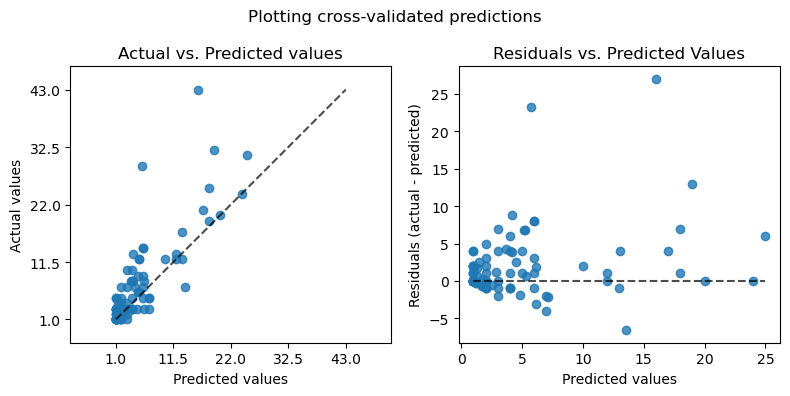

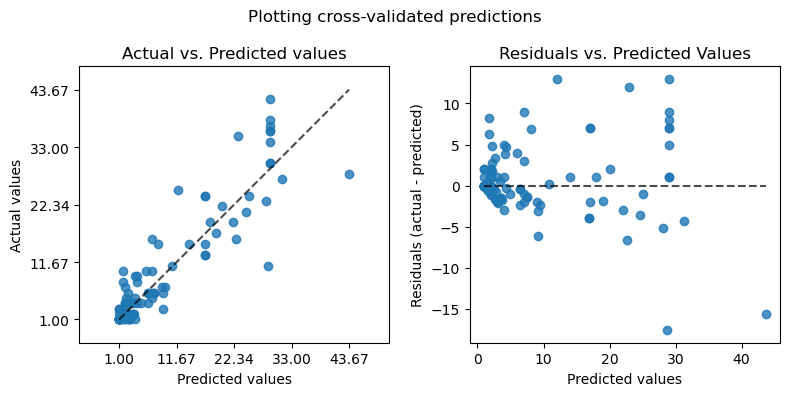

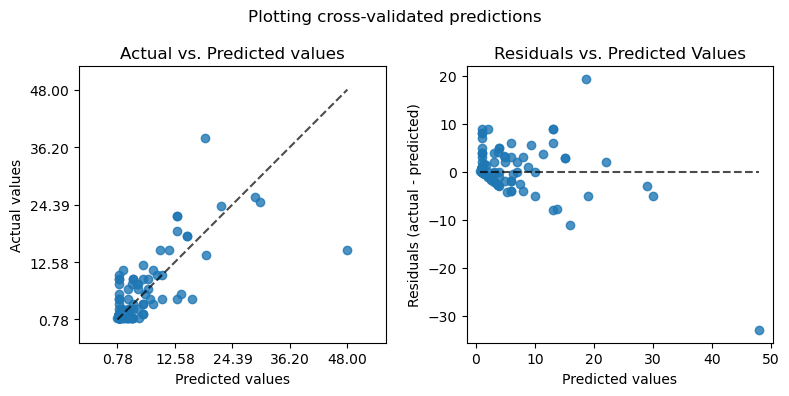

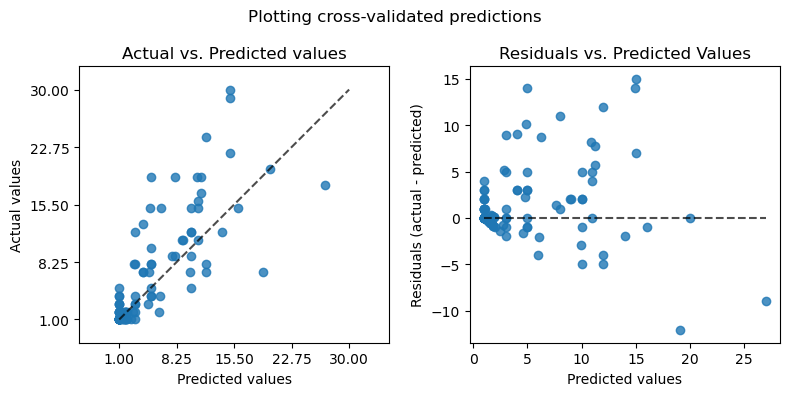

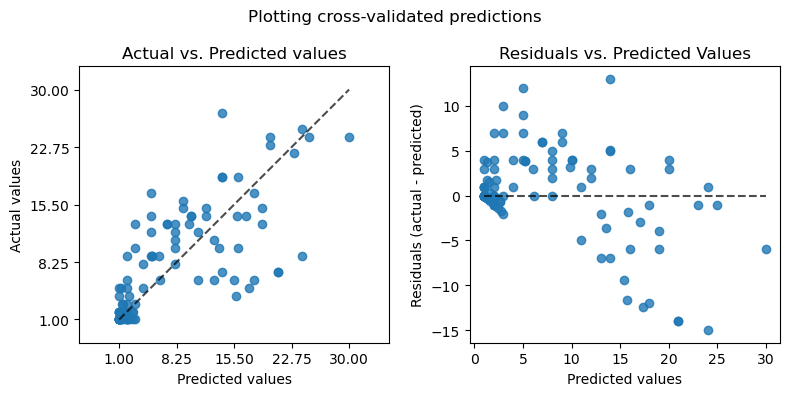

In [9]:
for idx,clf in enumerate(scores_classif['ExtraTreesRegressor']['estimator']):
    idx_train = scores_classif['ExtraTreesRegressor']['indices']['train'][idx]
    idx_test  = scores_classif['ExtraTreesRegressor']['indices']['test'][idx]

    X_train = train_data.loc[idx_train,:]
    y_train = target.loc[idx_train]
    X_test  = train_data.loc[idx_test,:]
    y_test  = target.loc[idx_test]

    y_pred = clf.fit(X_train,y_train).predict(X_test)

    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        subsample=100,
        ax=axs[0],
        random_state=0,
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        subsample=100,
        ax=axs[1],
        random_state=0,
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle("Plotting cross-validated predictions")
    plt.tight_layout()
    plt.show()

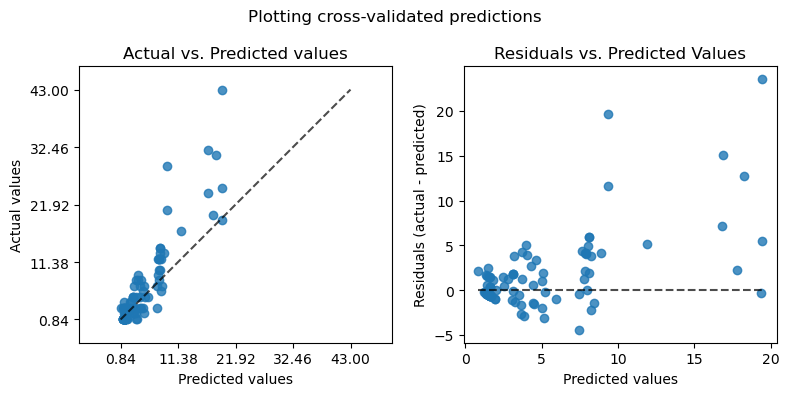

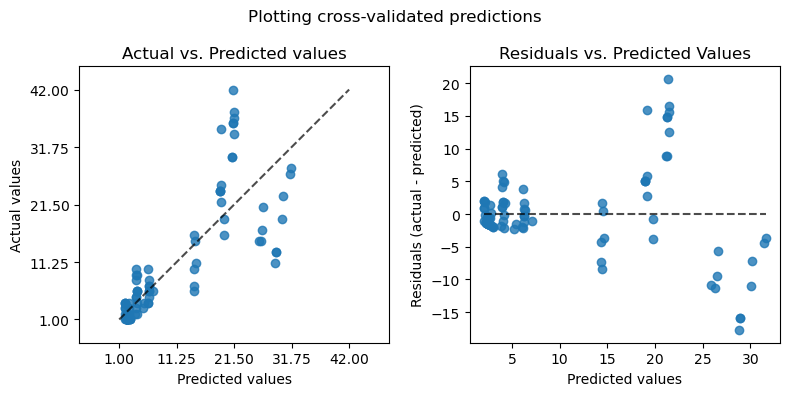

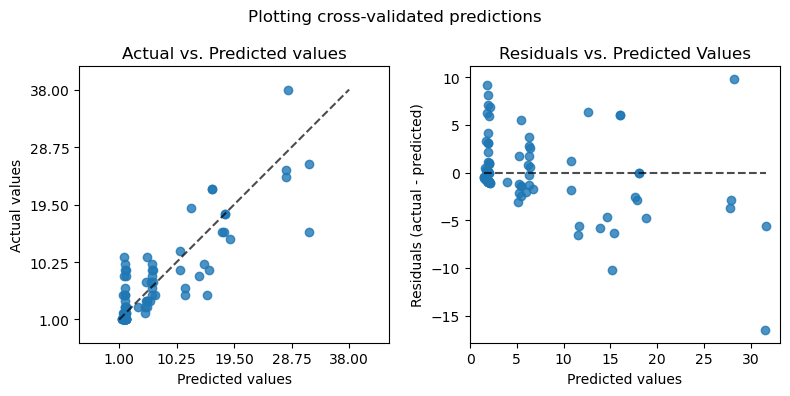

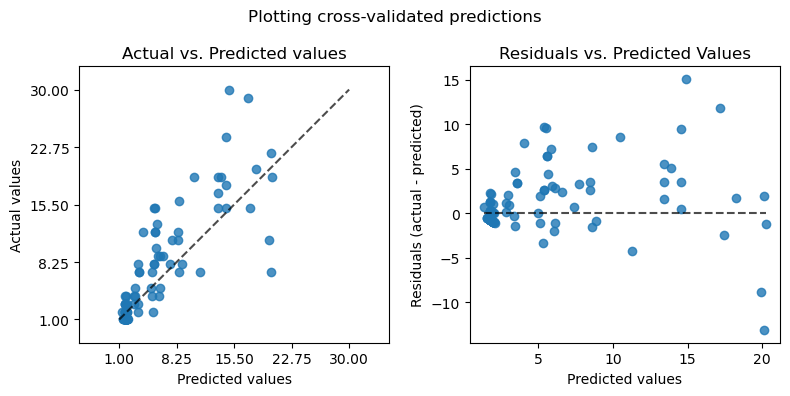

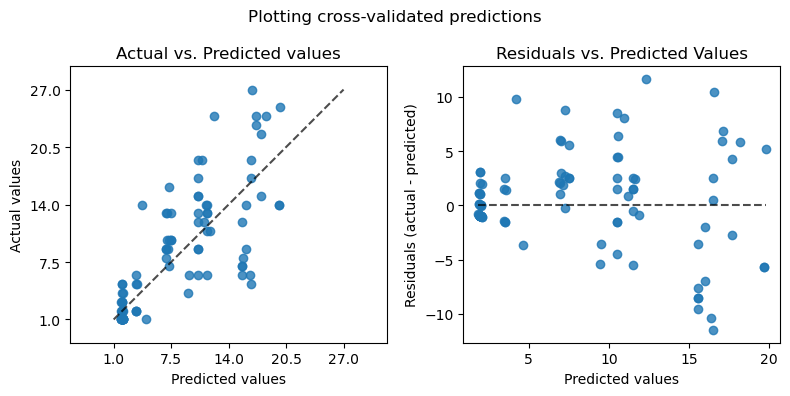

In [10]:
for idx,clf in enumerate(scores_classif['GradientBoostingRegressor']['estimator']):
    idx_train = scores_classif['GradientBoostingRegressor']['indices']['train'][idx]
    idx_test  = scores_classif['GradientBoostingRegressor']['indices']['test'][idx]

    X_train = train_data.loc[idx_train,:]
    y_train = target.loc[idx_train]
    X_test  = train_data.loc[idx_test,:]
    y_test  = target.loc[idx_test]

    y_pred = clf.fit(X_train,y_train).predict(X_test)

    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        subsample=100,
        ax=axs[0],
        random_state=0,
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        subsample=100,
        ax=axs[1],
        random_state=0,
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle("Plotting cross-validated predictions")
    plt.tight_layout()
    plt.show()